# Notebook: Esplorazione, pulizia e normalizzazione dei dati
Questo notebook esegue:
- caricamento dei CSV in `data/`
- ispezione iniziale (shape, dtypes, missing)
- pulizia e normalizzazione di ID e date
- salvataggio dei dataset puliti in `data/processed`

In [4]:
# Celle di setup: import e impostazioni
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import joblib

# impostazioni display pandas
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

# crea cartella per dati processati
os.makedirs('data/processed', exist_ok=True)

In [5]:
# Definizione dei percorsi dei file (relativi alla workspace)
paths = {
    'prediction_mapping': 'data/prediction_mapping.csv',
    'sample_submission': 'data/sample_submission.csv',
    'materials': 'data/extended/materials.csv',
    'transportation': 'data/extended/transportation.csv',
    'purchase_orders': 'data/kernel/purchase_orders.csv',
    'receivals': 'data/kernel/receivals.csv',
}

for k,v in paths.items():
    print(f"{k}: {v}")

prediction_mapping: data/prediction_mapping.csv
sample_submission: data/sample_submission.csv
materials: data/extended/materials.csv
transportation: data/extended/transportation.csv
purchase_orders: data/kernel/purchase_orders.csv
receivals: data/kernel/receivals.csv


In [6]:
# Caricamento CSV principali (attenzione: alcuni file sono grandi)
print('Caricamento dei file...')
prediction_mapping = pd.read_csv(paths['prediction_mapping'], low_memory=False)
sample_submission = pd.read_csv(paths['sample_submission'], low_memory=False)
materials = pd.read_csv(paths['materials'], low_memory=False)
transportation = pd.read_csv(paths['transportation'], low_memory=False)
purchase_orders = pd.read_csv(paths['purchase_orders'], low_memory=False)
receivals = pd.read_csv(paths['receivals'], low_memory=False)

dfs = {
    'prediction_mapping': prediction_mapping,
    'sample_submission': sample_submission,
    'materials': materials,
    'transportation': transportation,
    'purchase_orders': purchase_orders,
    'receivals': receivals,
}

for name, df in dfs.items():
    print(f"{name}: shape={df.shape}, memory={df.memory_usage(deep=True).sum()/1024**2:.2f} MB")

Caricamento dei file...
prediction_mapping: shape=(30450, 4), memory=3.89 MB
sample_submission: shape=(30450, 2), memory=0.46 MB
materials: shape=(1218, 6), memory=0.18 MB
transportation: shape=(122590, 23), memory=39.87 MB
purchase_orders: shape=(33171, 12), memory=12.98 MB
receivals: shape=(122590, 10), memory=23.03 MB


In [7]:
# 1) Ispezione iniziale: head e dtypes per ogni dataframe
for name, df in dfs.items():
    print('\n' + '='*80)
    print(f"DataFrame: {name}")
    display(df.head())
    print('\nDtypes:')
    print(df.dtypes)
    try:
        print('\nInfo:')
        df.info()
    except Exception as e:
        pass


DataFrame: prediction_mapping


,ID,rm_id,forecast_start_date,forecast_end_date
0,1,365,2025-01-01,2025-01-02
1,2,365,2025-01-01,2025-01-03
2,3,365,2025-01-01,2025-01-04
3,4,365,2025-01-01,2025-01-05
4,5,365,2025-01-01,2025-01-06



Dtypes:
ID                      int64
rm_id                   int64
forecast_start_date    object
forecast_end_date      object
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30450 entries, 0 to 30449
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   30450 non-null  int64 
 1   rm_id                30450 non-null  int64 
 2   forecast_start_date  30450 non-null  object
 3   forecast_end_date    30450 non-null  object
dtypes: int64(2), object(2)
memory usage: 951.7+ KB

DataFrame: sample_submission


,ID,predicted_weight
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0



Dtypes:
ID                  int64
predicted_weight    int64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30450 entries, 0 to 30449
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ID                30450 non-null  int64
 1   predicted_weight  30450 non-null  int64
dtypes: int64(2)
memory usage: 475.9 KB

DataFrame: materials


,rm_id,product_id,product_version,raw_material_alloy,raw_material_format_type,stock_location
0,NaN,NaN,NaN,NaN,NaN,NaN
1,342.0,91900170.0,1.0,SB06 Traders,24.0,DELETED_28.02:2011_SB06 anodiz
2,343.0,91900143.0,2.0,SB02 606035,24.0,SB 02
3,345.0,91900143.0,2.0,SA10 606035,3.0,DELETED_28.02:2011_ST01
4,346.0,91900146.0,2.0,SA15 600540,3.0,DELETED_28.02:2011_SA 300370



Dtypes:
rm_id                       float64
product_id                  float64
product_version             float64
raw_material_alloy           object
raw_material_format_type    float64
stock_location               object
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   rm_id                     1217 non-null   float64
 1   product_id                1217 non-null   float64
 2   product_version           1217 non-null   float64
 3   raw_material_alloy        1217 non-null   object 
 4   raw_material_format_type  1217 non-null   float64
 5   stock_location            1217 non-null   object 
dtypes: float64(4), object(2)
memory usage: 57.2+ KB

DataFrame: transportation


,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,transporter_name,vehicle_no,unit_status,vehicle_start_weight,vehicle_end_weight,gross_weight,tare_weight,net_weight,wood,ironbands,plastic,water,ice,other,chips,packaging,cardboard
0,365.0,91900143.0,208545.0,10.0,1,NaN,Transporter0,Vehicle0,Transferred,40040.0,14740.0,11540.0,120.0,11420.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,365.0,91900143.0,208545.0,10.0,2,NaN,Transporter0,Vehicle0,Transferred,40040.0,14740.0,13760.0,0.0,13760.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,365.0,91900143.0,208490.0,10.0,1,NaN,Transporter1,Vehicle1,Transferred,39940.0,15280.0,11577.0,296.0,11281.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,365.0,91900143.0,208490.0,10.0,2,NaN,Transporter1,Vehicle1,Transferred,39940.0,15280.0,13083.0,0.0,13083.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,379.0,91900296.0,210435.0,20.0,1,NaN,Transporter2,Vehicle2,Transferred,39360.0,15180.0,24180.0,270.0,23910.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Dtypes:
rm_id                     float64
product_id                float64
purchase_order_id         float64
purchase_order_item_no    float64
receival_item_no            int64
batch_id                  float64
transporter_name           object
vehicle_no                 object
unit_status                object
vehicle_start_weight      float64
vehicle_end_weight        float64
gross_weight              float64
tare_weight               float64
net_weight                float64
wood                      float64
ironbands                 float64
plastic                   float64
water                     float64
ice                       float64
other                     float64
chips                     float64
packaging                 float64
cardboard                 float64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122590 entries, 0 to 122589
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------            

,purchase_order_id,purchase_order_item_no,quantity,delivery_date,product_id,product_version,created_date_time,modified_date_time,unit_id,unit,status_id,status
0,1,1,-14.0,2003-05-12 00:00:00.0000000 +02:00,91900143,1,2003-05-12 10:00:48.0000000 +00:00,2004-06-15 06:16:18.0000000 +00:00,NaN,NaN,2,Closed
1,22,1,23880.0,2003-05-27 00:00:00.0000000 +02:00,91900160,1,2003-05-27 12:42:07.0000000 +00:00,2012-06-29 09:41:13.0000000 +00:00,NaN,NaN,2,Closed
2,41,1,0.0,2004-03-08 00:00:00.0000000 +01:00,91900143,1,2004-03-08 13:44:31.0000000 +00:00,2012-07-04 13:51:02.0000000 +00:00,NaN,NaN,2,Closed
3,61,1,0.0,2004-03-10 00:00:00.0000000 +01:00,91900143,1,2004-03-10 11:39:06.0000000 +00:00,2012-07-04 13:50:59.0000000 +00:00,NaN,NaN,2,Closed
4,141,10,25000.0,2004-10-28 00:00:00.0000000 +02:00,91900143,1,2004-10-22 12:21:54.0000000 +00:00,2012-07-04 13:50:55.0000000 +00:00,NaN,NaN,2,Closed



Dtypes:
purchase_order_id           int64
purchase_order_item_no      int64
quantity                  float64
delivery_date              object
product_id                  int64
product_version             int64
created_date_time          object
modified_date_time         object
unit_id                   float64
unit                       object
status_id                   int64
status                     object
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33171 entries, 0 to 33170
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   purchase_order_id       33171 non-null  int64  
 1   purchase_order_item_no  33171 non-null  int64  
 2   quantity                33171 non-null  float64
 3   delivery_date           33171 non-null  object 
 4   product_id              33171 non-null  int64  
 5   product_version         33171 non-null  int64  
 6   created_date_time       

,rm_id,product_id,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,receival_status,net_weight,supplier_id
0,365.0,91900143.0,208545.0,10.0,1,NaN,2004-06-15 13:34:00 +02:00,Completed,11420.0,52062
1,365.0,91900143.0,208545.0,10.0,2,NaN,2004-06-15 13:34:00 +02:00,Completed,13760.0,52062
2,365.0,91900143.0,208490.0,10.0,1,NaN,2004-06-15 13:38:00 +02:00,Completed,11281.0,50468
3,365.0,91900143.0,208490.0,10.0,2,NaN,2004-06-15 13:38:00 +02:00,Completed,13083.0,50468
4,379.0,91900296.0,210435.0,20.0,1,NaN,2004-06-15 13:40:00 +02:00,Completed,23910.0,52577



Dtypes:
rm_id                     float64
product_id                float64
purchase_order_id         float64
purchase_order_item_no    float64
receival_item_no            int64
batch_id                  float64
date_arrival               object
receival_status            object
net_weight                float64
supplier_id                 int64
dtype: object

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122590 entries, 0 to 122589
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   rm_id                   122533 non-null  float64
 1   product_id              122533 non-null  float64
 2   purchase_order_id       122537 non-null  float64
 3   purchase_order_item_no  122537 non-null  float64
 4   receival_item_no        122590 non-null  int64  
 5   batch_id                64765 non-null   float64
 6   date_arrival            122590 non-null  object 
 7   receival_status         1225

In [8]:
# 2) Missing-value summary e unique counts per colonne chiave
def missing_summary(df):
    miss = df.isnull().sum().rename('missing_count')
    pct = (df.isnull().mean()*100).rename('missing_pct')
    return pd.concat([miss, pct], axis=1).sort_values('missing_count', ascending=False)

keys = ['rm_id','product_id','purchase_order_id']
for name, df in dfs.items():
    print('\n' + '-'*60)
    print(f"Dataset: {name} - shape {df.shape}")
    ms = missing_summary(df)
    display(ms.head(20))
    for k in keys:
        if k in df.columns:
            print(f"Unique count {k}: {df[k].nunique(dropna=True)}")


------------------------------------------------------------
Dataset: prediction_mapping - shape (30450, 4)


,missing_count,missing_pct
ID,0,0.0
rm_id,0,0.0
forecast_start_date,0,0.0
forecast_end_date,0,0.0


Unique count rm_id: 203

------------------------------------------------------------
Dataset: sample_submission - shape (30450, 2)


,missing_count,missing_pct
ID,0,0.0
predicted_weight,0,0.0



------------------------------------------------------------
Dataset: materials - shape (1218, 6)


,missing_count,missing_pct
rm_id,1,0.082102
product_id,1,0.082102
product_version,1,0.082102
raw_material_alloy,1,0.082102
raw_material_format_type,1,0.082102
stock_location,1,0.082102


Unique count rm_id: 203
Unique count product_id: 54

------------------------------------------------------------
Dataset: transportation - shape (122590, 23)


,missing_count,missing_pct
chips,114801,93.646301
ice,114796,93.642222
water,114792,93.638959
cardboard,114757,93.610409
packaging,114739,93.595726
other,114193,93.150339
ironbands,111502,90.955217
plastic,106573,86.934497
wood,97313,79.380863
batch_id,57825,47.169427


Unique count rm_id: 203
Unique count product_id: 54
Unique count purchase_order_id: 7173

------------------------------------------------------------
Dataset: purchase_orders - shape (33171, 12)


,missing_count,missing_pct
modified_date_time,492,1.483223
unit_id,44,0.132646
unit,44,0.132646
purchase_order_id,0,0.000000
purchase_order_item_no,0,0.000000
quantity,0,0.000000
delivery_date,0,0.000000
product_id,0,0.000000
product_version,0,0.000000
created_date_time,0,0.000000


Unique count product_id: 77
Unique count purchase_order_id: 8135

------------------------------------------------------------
Dataset: receivals - shape (122590, 10)


,missing_count,missing_pct
batch_id,57825,47.169427
net_weight,68,0.055469
rm_id,57,0.046496
product_id,57,0.046496
purchase_order_id,53,0.043234
purchase_order_item_no,53,0.043234
receival_item_no,0,0.000000
date_arrival,0,0.000000
receival_status,0,0.000000
supplier_id,0,0.000000


Unique count rm_id: 203
Unique count product_id: 54
Unique count purchase_order_id: 7173


In [9]:
# 3) Funzioni di pulizia/normalizzazione tipi e parsing date
def to_int64_nullable(s):
    # rimuove .0 finale quando presente e converte con Int64 (nullable)
    s = s.replace(r"\.0$", "", regex=True).astype('Int64')
    return s

def normalize_id_columns(df, cols):
    for c in cols:
        if c in df.columns:
            # gestisci stringhe vuote
            df[c] = df[c].replace('', pd.NA)
            # se float -> converti mantenendo NaN
            df[c] = pd.to_numeric(df[c], errors='coerce')
            # converti a Int64 nullable quando possibile
            df[c] = df[c].where(df[c].notna(), pd.NA).astype('Int64')
    return df

# parsing date helper
def try_parse_dates(df, date_cols):
    for c in date_cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
    return df

# Applica conversioni su tutti i dataframe rilevanti
id_cols_by_df = {
    'prediction_mapping':['rm_id'],
    'materials':['rm_id','product_id'],
    'transportation':['rm_id','product_id','purchase_order_id','purchase_order_item_no','receival_item_no'],
    'purchase_orders':['purchase_order_id','product_id','purchase_order_item_no'],
    'receivals':['rm_id','product_id','purchase_order_id','purchase_order_item_no','receival_item_no'],
}

date_cols_by_df = {
    'purchase_orders':['delivery_date','created_date_time','modified_date_time'],
    'receivals':['date_arrival'],
    'prediction_mapping':['forecast_start_date','forecast_end_date'],
}

for name, df in dfs.items():
    cols = id_cols_by_df.get(name, [])
    if cols:
        dfs[name] = normalize_id_columns(df, cols)
    dcols = date_cols_by_df.get(name, [])
    if dcols:
        dfs[name] = try_parse_dates(dfs[name], dcols)

# pulizia testo per materials: drop righe vuote e strip
if 'materials' in dfs:
    m = dfs['materials']
    # sostituisci stringhe vuote con NaN e drop righe completamente vuote
    m = m.replace('', pd.NA).dropna(how='all')
    # trim whitespace su colonne stringa
    str_cols = m.select_dtypes(include='object').columns.tolist()
    for c in str_cols:
        m[c] = m[c].astype('string').str.strip()
    dfs['materials'] = m

/var/folders/y_/z30sh81d7sg8pkp71bmjxf0h0000gn/T/ipykernel_56573/122063182.py:22: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[c] = pd.to_datetime(df[c], errors='coerce')
/var/folders/y_/z30sh81d7sg8pkp71bmjxf0h0000gn/T/ipykernel_56573/122063182.py:22: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df[c] = pd.to_datetime(df[c], errors='coerce')


In [10]:
# 4) Sanity checks: distribuzioni e confronto net_weight
for name in ['receivals','transportation']:
    if name in dfs:
        print('\n' + '='*60)
        print(f"Statistiche net_weight per {name}")
        if 'net_weight' in dfs[name].columns:
            display(dfs[name]['net_weight'].describe())
        else:
            print('Colonna net_weight non presente')

# confronta counts per purchase_order_id tra receivals e transportation
if 'receivals' in dfs and 'transportation' in dfs:
    r_counts = dfs['receivals'].groupby('purchase_order_id').size().rename('receivals_count')
    t_counts = dfs['transportation'].groupby('purchase_order_id').size().rename('transportation_count')
    counts = pd.concat([r_counts, t_counts], axis=1).fillna(0).astype('int64')
    display(counts.sort_values(['receivals_count','transportation_count'], ascending=False).head(10))


Statistiche net_weight per receivals


count    122522.000000
mean      12972.566543
std        8264.652621
min           0.000000
25%        5660.000000
50%       12380.000000
75%       21120.000000
max       31626.000000
Name: net_weight, dtype: float64


Statistiche net_weight per transportation


count    122522.000000
mean      12972.566543
std        8264.652621
min           0.000000
25%        5660.000000
50%       12380.000000
75%       21120.000000
max       31626.000000
Name: net_weight, dtype: float64

,receivals_count,transportation_count
purchase_order_id,,
300251,977,977
212960,939,939
212958,675,675
212970,565,565
212977,534,534
295350,533,533
212961,489,489
295346,477,477
307605,468,468


In [11]:
# 5) Esempio di merge per un purchase_order sample e controllo mismatch
sample_po = None
if not purchase_orders.empty:
    sample_po = purchase_orders['purchase_order_id'].dropna().unique()[0]
    print(f"Esempio purchase_order_id sample: {sample_po}")
    r_sub = dfs['receivals'][dfs['receivals']['purchase_order_id'] == sample_po]
    t_sub = dfs['transportation'][dfs['transportation']['purchase_order_id'] == sample_po]
    print('receivals slice shape:', r_sub.shape)
    print('transportation slice shape:', t_sub.shape)
    # merge sui campi item quando presenti
    merged = pd.merge(r_sub, t_sub, how='outer', left_on=['purchase_order_id','receival_item_no'], right_on=['purchase_order_id','receival_item_no'], suffixes=('_rec','_trans'))
    display(merged.head(20))
else:
    print('Nessun purchase_orders disponibile per sample')

Esempio purchase_order_id sample: 1
receivals slice shape: (0, 10)
transportation slice shape: (0, 23)


,rm_id_rec,product_id_rec,purchase_order_id,purchase_order_item_no_rec,receival_item_no,batch_id_rec,date_arrival,receival_status,net_weight_rec,supplier_id,rm_id_trans,product_id_trans,purchase_order_item_no_trans,batch_id_trans,transporter_name,vehicle_no,unit_status,vehicle_start_weight,vehicle_end_weight,gross_weight,tare_weight,net_weight_trans,wood,ironbands,plastic,water,ice,other,chips,packaging,cardboard


In [12]:
# 6) Salvataggio dei dataset puliti in data/processed
for name, df in dfs.items():
    out_path = f"data/processed/{name}_cleaned.csv"
    try:
        df.to_csv(out_path, index=False)
        print(f"Salvato: {out_path} (shape={df.shape})")
    except Exception as e:
        print(f"Errore salvando {name}: {e}")

Salvato: data/processed/prediction_mapping_cleaned.csv (shape=(30450, 4))
Salvato: data/processed/sample_submission_cleaned.csv (shape=(30450, 2))
Salvato: data/processed/materials_cleaned.csv (shape=(1217, 6))
Salvato: data/processed/transportation_cleaned.csv (shape=(122590, 23))
Salvato: data/processed/purchase_orders_cleaned.csv (shape=(33171, 12))
Salvato: data/processed/receivals_cleaned.csv (shape=(122590, 10))


Date normalizzate a UTC (quando possibile)


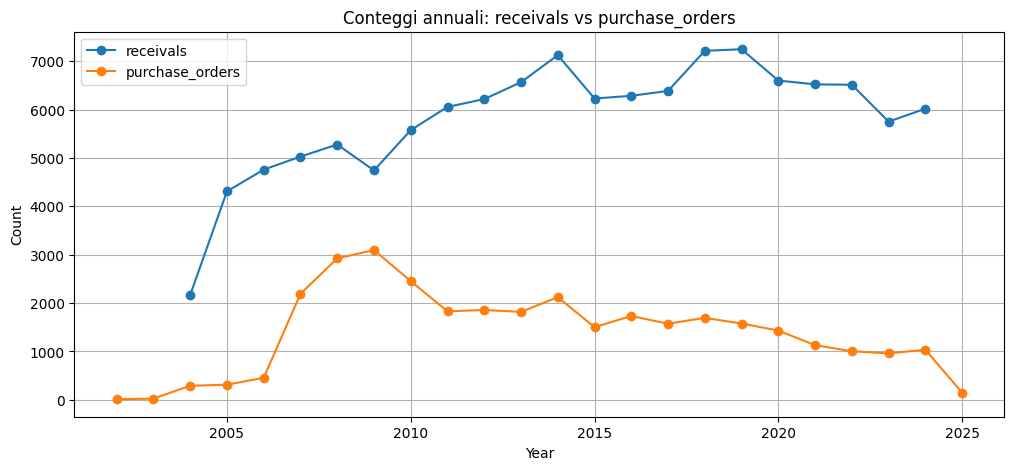

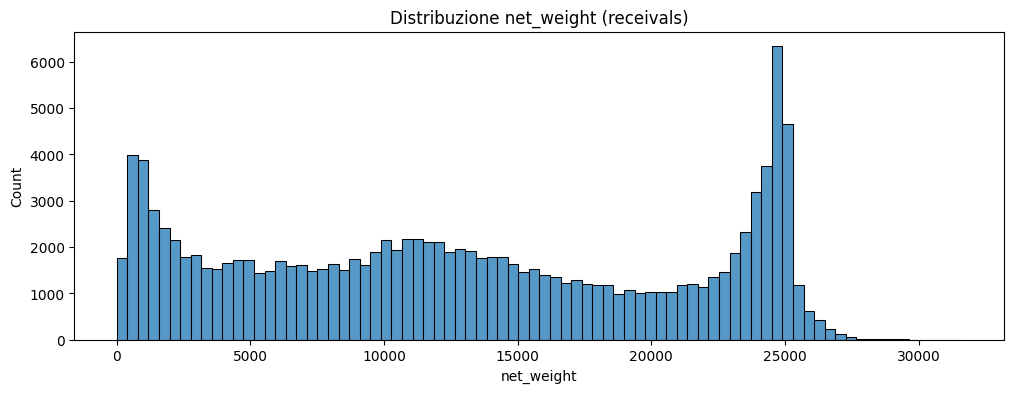

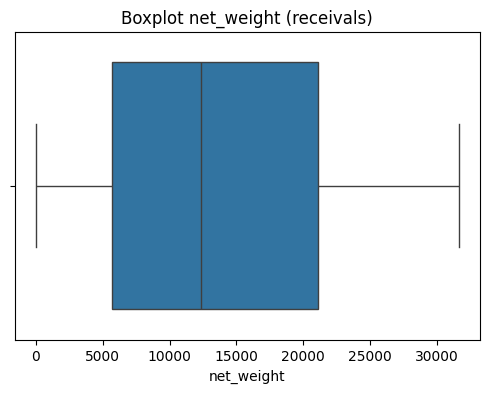

In [13]:
## Normalizzazione date (UTC) e visualizzazioni temporali
# Normalizzo le colonne date principali in UTC per avere coerenza nelle aggregazioni
date_cols_all = {
    'prediction_mapping':['forecast_start_date','forecast_end_date'],
    'purchase_orders':['delivery_date','created_date_time','modified_date_time'],
    'receivals':['date_arrival'],
}
for name, cols in date_cols_all.items():
    if name in dfs:
        for c in cols:
            if c in dfs[name].columns:
                dfs[name][c] = pd.to_datetime(dfs[name][c], errors='coerce', utc=True)
print('Date normalizzate a UTC (quando possibile)')

# Visualizzazioni: conteggi per anno e per mese dei receivals e purchase_orders
plt.figure(figsize=(12,5))
if 'receivals' in dfs:
    r = dfs['receivals'].copy()
    r['year'] = r['date_arrival'].dt.year
    r_year = r.groupby('year').size()
    plt.plot(r_year.index, r_year.values, marker='o', label='receivals')
if 'purchase_orders' in dfs:
    p = dfs['purchase_orders'].copy()
    # delivery_date può essere NaT dopo parsing; usare created_date_time come fallback per trend
    p['year'] = p['delivery_date'].dt.year.fillna(p['created_date_time'].dt.year)
    p_year = p.groupby('year').size()
    plt.plot(p_year.index, p_year.values, marker='o', label='purchase_orders')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Conteggi annuali: receivals vs purchase_orders')
plt.legend()
plt.grid(True)
plt.show()

# Istogramma net_weight (receivals) e boxplot rapido
if 'receivals' in dfs:
    plt.figure(figsize=(12,4))
    sns.histplot(dfs['receivals']['net_weight'].dropna(), bins=80, kde=False)
    plt.title('Distribuzione net_weight (receivals)')
    plt.xlabel('net_weight')
    plt.show()

    plt.figure(figsize=(6,4))
    sns.boxplot(x=dfs['receivals']['net_weight'].dropna())
    plt.title('Boxplot net_weight (receivals)')
    plt.show()

In [14]:
## Costruzione tabella master per modelling
# Strategia: per ogni riga di `prediction_mapping` (ID con rm_id + forecast window)
# - unisco metadata da materials
# - calcolo aggregazioni storiche su receivals per il relativo `rm_id`
# - calcolo feature nello window [forecast_start_date - 365d, forecast_start_date)
pm = dfs['prediction_mapping'].copy()
# assicuriamoci che forecast_start_date sia datetime UTC
pm['forecast_start_date'] = pd.to_datetime(pm['forecast_start_date'], errors='coerce', utc=True)
pm['forecast_end_date'] = pd.to_datetime(pm['forecast_end_date'], errors='coerce', utc=True)

# aggregazioni globali per rm_id (storico)
rec = dfs['receivals'].copy()
# assicurarsi date coerenti
rec['date_arrival'] = pd.to_datetime(rec['date_arrival'], errors='coerce', utc=True)
agg_all = rec.groupby('rm_id').agg(total_received_all=('net_weight','sum'),
                                       mean_received_all=('net_weight','mean'),
                                       std_received_all=('net_weight','std'),
                                       count_received_all=('net_weight','count'),
                                       last_receival_date=('date_arrival','max'))
agg_all = agg_all.reset_index()

# per velocizzare calcoli window, creo mapping rm_id -> dataframe ordinato per date
rm_to_df = {}
for rid, g in rec.groupby('rm_id'):
    g2 = g[['date_arrival','net_weight']].sort_values('date_arrival')
    rm_to_df[rid] = g2

# funzione che, dato rm_id e forecast_start_date, calcola sum/mean/count nell'ultimo anno
def features_for_row(rm_id, start_dt):
    out = {'sum_365': pd.NA, 'mean_365': pd.NA, 'count_365': 0, 'last_net_weight': pd.NA}
    if pd.isna(rm_id) or rm_id not in rm_to_df or pd.isna(start_dt):
        return out
    df_rm = rm_to_df[rm_id]
    window_start = start_dt - pd.Timedelta(days=365)
    mask = (df_rm['date_arrival'] < start_dt) & (df_rm['date_arrival'] >= window_start)
    sel = df_rm.loc[mask, 'net_weight']
    if sel.size>0:
        out['sum_365'] = sel.sum()
        out['mean_365'] = sel.mean()
        out['count_365'] = int(sel.count())
    # last net weight before start_dt
    prior = df_rm[df_rm['date_arrival'] < start_dt]
    if not prior.empty:
        out['last_net_weight'] = prior.sort_values('date_arrival')['net_weight'].iloc[-1]
    return out

# Applico la funzione riga-per-riga su pm (attenzione: operazione relativamente costosa ma fattibile)
feat_rows = []
for idx, row in pm.iterrows():
    rid = row.get('rm_id')
    start_dt = row.get('forecast_start_date')
    feats = features_for_row(rid, start_dt)
    feat_rows.append(feats)

feat_df = pd.DataFrame(feat_rows)
master = pd.concat([pm.reset_index(drop=True), feat_df.reset_index(drop=True)], axis=1)

# unisco metadata materials su rm_id (se presente)
if 'materials' in dfs:
    master = master.merge(dfs['materials'].drop_duplicates(subset=['rm_id']), how='left', on='rm_id')

# unisco aggregazioni storiche all-time (agg_all) su rm_id
master = master.merge(agg_all, how='left', on='rm_id')

# salvo master per modelling
master_path = 'data/processed/master_for_modeling.csv'
master.to_csv(master_path, index=False)
print('Salvato master:', master_path, 'shape:', master.shape)

Salvato master: data/processed/master_for_modeling.csv shape: (30450, 18)
